In [1]:
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
pd.get_option("display.max_columns",100)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

20

In [2]:
###Load top songs database###
Eng_df = pd.read_csv('./Data/English.csv')
#'https://raw.githubusercontent.com/stekim/ece228lyricsgenre/master/top500songs_lyrics_genre.csv')[['SongInfo','Lyrics','Genre']]
Eng_df.rename(columns={'SongInfo': 'song', 'Lyrics': 'lyrics','Genre':'genre','Idiom':'idiom'}, inplace = True)
#Load additional 730 songs
#more_top_songs_df = pd.read_csv('https://raw.githubusercontent.com/bjherger/LyricsGenreIdentification/master/code/data%20gathering/output/songs_full_with_lyrics.csv')[['song','lyrics','genre']]
#combine dfs
top_1200_songs_df = Eng_df
top_1200_songs_df= top_1200_songs_df[['song','lyrics','genre','idiom']]

In [3]:
top_1200_songs_df.genre.unique()



array(["'Rock'", "'Pop'", "'Hip Hop'", "'Sertanejo'", "'Samba'",
       "'Funk Carioca'"], dtype=object)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6788: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


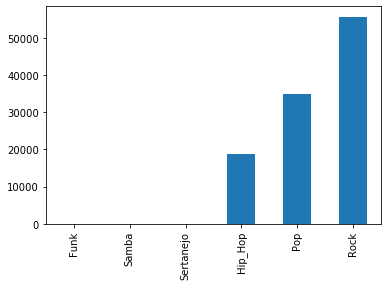

In [4]:
# Maybe we have a chart to show what genre's each dataset has
top_1200_songs_df.genre.replace("'Rock'","Rock", inplace=True)
top_1200_songs_df.genre.replace("'Pop'","Pop", inplace=True)
top_1200_songs_df.genre.replace("'Hip Hop'","Hip_Hop", inplace=True)
top_1200_songs_df.genre.replace("'Samba'","Samba", inplace=True)
top_1200_songs_df.genre.replace("'Funk Carioca'","Funk", inplace=True)
top_1200_songs_df.genre.replace("'Sertanejo'","Sertanejo", inplace=True)
top_1200_songs_df.genre.value_counts().sort_values().plot(kind = 'bar') 

In [5]:
#Clean_text function
top_1200_songs_df = top_1200_songs_df.reset_index(drop=True)
remove_special_chars = re.compile('[-/(){}\´[\]\|@,©;¡ª§£³]')
remove_other_chars = re.compile('[^0-9a-z #+_ Ã ]')
stopwords = nltk.corpus.stopwords.words('english')


def clean_text(text):
    text = str(text)
    text = text.lower() 
    text = remove_special_chars.sub(' ', text)
    text = remove_other_chars.sub('', text)  
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in stopwords) # remove stopwors from text
    return text

In [6]:
top_1200_songs_df['lyrics'] = top_1200_songs_df['lyrics'].apply(clean_text)

In [7]:
top_1200_songs_df.dropna(inplace=True)
top_1200_songs_df.count()

song      109424
lyrics    109424
genre     109424
idiom     109424
dtype: int64

In [8]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(top_1200_songs_df['lyrics'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 127889 unique tokens.


In [9]:
# word_index
# 
# {'im': 1,
#  'like': 2,
#  'know': 3,
#  'love': 4,
#  'dont': 5,
#  'get': 6,
#  'got': 7,
#  'wanna': 8,
#  ....
# 


In [10]:
#make all lyrics the same length with "pad_sequences", so that we can do operations on each data point
X = tokenizer.texts_to_sequences(top_1200_songs_df['lyrics'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (109424, 250)


In [11]:

#get our y labels
Y = pd.get_dummies(top_1200_songs_df['genre']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (109424, 6)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(76596, 250) (76596, 6)
(32828, 250) (32828, 6)


In [13]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
____________________________________________________________

In [14]:
epochs = 50
batch_size = 1000

history = model.fit(X_train, Y_train, epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 68936 samples, validate on 7660 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
68936/68936 [==============================] - 71s 1ms/sample - loss: 1.0300 - acc: 0.5605 - val_loss: 0.8778 - val_acc: 0.6012
Epoch 2/50
68936/68936 [==============================] - 68s 988us/sample - loss: 0.8632 - acc: 0.6007 - val_loss: 0.8481 - val_acc: 0.6176
Epoch 3/50
68936/68936 [==============================] - 68s 981us/sample - loss: 0.7998 - acc: 0.6316 - val_loss: 0.7452 - val_acc: 0.6650
Epoch 4/50
68936/68936 [==============================] - 68s 982us/sample - loss: 0.7274 - acc: 0.6705 - val_loss: 0.7067 - val_acc: 0.6868
Epoch 5/50
68936/68936 [==============================] - 68s 984us/sample - loss: 0.6706 - acc: 0.7010 - val_loss: 0.6838 - val_acc: 0.7010
Epoch 6/50
68936/68936 [==============================] - 67s 966us/sample - loss: 0.6297 - acc: 0.7244 - val_loss: 0.6635 - val_acc: 0.7157
Epoch 7/50
68

In [15]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [16]:

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32828/32828 [==============================] - 309s 9ms/sample - loss: 0.6453 - acc: 0.7557
Test set
  Loss: 0.645
  Accuracy: 0.756


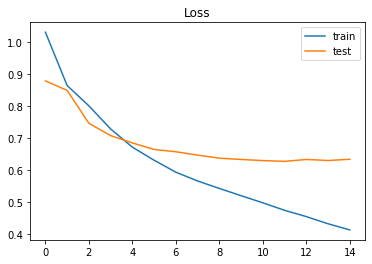

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();



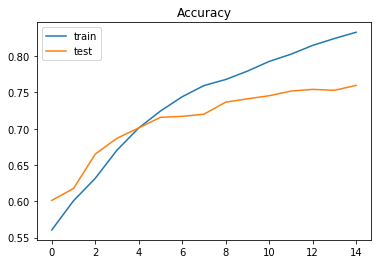

In [18]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();